**Goal**: To build a text-to-level generator for 2D tile-based games (like mazes), and visualize using Python libraries.

**Agenda**: To create a Maze Generator using LangGraph Multi-Agent Supervisor, game developers describe their level ideas in natural language, and AI agents generate full levels (maze).

**Multi-Agent Architecture**:
- **Supervisor agent**: Specialized agents are coordinated by a central supervisor agent. The supervisor controls all communication flow and task delegation, making decisions about which agent to invoke based on the current context and task requirements.
- **Design Intent Agent**: Understands what the user wants by picking out key details like the theme, number of enemies, and level size.
- **Layout Agent**: Builds a basic game map as a 2D grid (like a 10x10 board), showing the ground, walls, and paths using NumPy. Fills the map with fun stuff like enemies, traps, or goals using simple rules and NumPy.
- **Test Agent**: Makes sure there’s a valid path through the level and shows what the map looks like. It uses BFS (a pathfinding method) and tools like matplotlib.
- **Render Image Agent**: That converts the grid to image.


**Install all the necessary packages**

In [1]:
!pip install -U langchain-community langgraph langchain-anthropic tavily-python langgraph-checkpoint-sqlite
!pip install -qU "langchain[mistralai]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.3/289.3 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.9/438.9 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found 

In [2]:
!pip install -U langgraph langgraph-supervisor langchain-tavily "langchain[openai]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 5.9 MB/s eta 0:00:00


In [3]:
!pip install -q -U google-genai
!pip install -U langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.4/206.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.2 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


**Import necessary packages**

In [4]:
import requests
import json
from collections import Counter
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.chat_models import init_chat_model
from langchain.schema import HumanMessage
from langchain.tools import tool
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from typing import List
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model
import gradio as gr
import re
from PIL import Image
import os
from langchain_core.messages import convert_to_messages

**LLMs used in the project are Mistral and Google gemini: Get and define the API keys**

In [89]:
MISTRAL_API_KEY = "MISTRAL_API_KEY"
os.environ["MISTRAL_API_KEY"] = MISTRAL_API_KEY
GOOGLE_API_KEY = "GOOGLE_API_KEY"
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

**Define pretty_print_messages to nicely format and display messages**


In [76]:
def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

**Create design intent agent**

In [77]:
@tool
def parse_design_intent(prompt: str) -> dict:
    """
    Parses level design prompt into structured configuration.
    E.g. "a spooky forest with 2 enemies and 1 trap"
    """
    import re
    config = {"theme": "generic", "enemies": 0, "traps": 0}

    if "spooky" in prompt.lower():
        config["theme"] = "spooky"

    enemies = re.search(r"(\d+)\s*enemies?", prompt)
    traps = re.search(r"(\d+)\s*traps?", prompt)

    if enemies: config["enemies"] = int(enemies.group(1))
    if traps: config["traps"] = int(traps.group(1))

    return config

design_intent_agent = create_react_agent(
    model="mistral-large-latest",
    tools=[parse_design_intent],
    prompt=(
        "You are a design intent parsing agent.\n"
        "- Take user level prompts and extract theme, number of enemies, traps.\n"
        "- Return only the structured config dictionary.\n"
        "- Do not include any extra explanation."
    ),
    name="design_intent_agent"
)

**Create layout agent**

In [78]:
@tool
def generate_level_layout(config: dict) -> list:
    """
    Generates a maze-like 2D grid based on the config.
    Tiles: 'P'=Path, 'W'=Wall, 'E'=Enemy, 'T'=Trap, 'S'=Start, 'G'=Goal
    """
    import numpy as np
    from random import randint, shuffle
    from collections import deque

    size = 11  # Must be odd for proper maze
    grid = [["W" for _ in range(size)] for _ in range(size)]

    def carve(x, y):
        dirs = [(0, 2), (0, -2), (2, 0), (-2, 0)]
        shuffle(dirs)
        for dx, dy in dirs:
            nx, ny = x + dx, y + dy
            if 1 <= nx < size - 1 and 1 <= ny < size - 1 and grid[nx][ny] == "W":
                grid[x + dx // 2][y + dy // 2] = "P"
                grid[nx][ny] = "P"
                carve(nx, ny)

    def is_solvable(g):
        visited = set()
        queue = deque([(1, 1)])
        while queue:
            x, y = queue.popleft()
            if (x, y) == (size - 2, size - 2):
                return True
            for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < size and 0 <= ny < size and g[nx][ny] in {"P", "G"} and (nx, ny) not in visited:
                    visited.add((nx, ny))
                    queue.append((nx, ny))
        return False

    def place_items_safely(grid):
        temp_grid = [row[:] for row in grid]
        def place_item(symbol, count):
            placed = 0
            tries = 0
            while placed < count and tries < 100:
                x, y = randint(1, size - 2), randint(1, size - 2)
                if temp_grid[x][y] == "P":
                    temp_grid[x][y] = symbol
                    if is_solvable(temp_grid):
                        placed += 1
                    else:
                        temp_grid[x][y] = "P"
                tries += 1
        place_item("E", config.get("enemies", 2))
        place_item("T", config.get("traps", 1))
        return temp_grid

    # Generate maze
    grid[1][1] = "P"
    carve(1, 1)
    grid[1][1] = "S"
    grid[size - 2][size - 2] = "G"

    # Safely place enemies and traps
    final_grid = place_items_safely(grid)

    return final_grid


layout_agent = create_react_agent(
    model="google_genai:gemini-2.0-flash",
    tools=[generate_level_layout],
    prompt=(
        "You are a layout generation agent.\n"
        "- Take level config and return a valid grid layout (as a list of lists).\n"
        "- Place start at (1,1), goal at bottom right, enemies and traps randomly.\n"
        "- No additional explanation."
    ),
    name="layout_agent"
)

**Define test agent**

In [79]:
@tool
def evaluate_level(grid: list) -> dict:
    """
    Checks if path exists from start to goal (very simple BFS),
    and returns a basic difficulty estimate.
    """
    from collections import deque

    def bfs(grid):
        rows, cols = len(grid), len(grid[0])
        visited = [[False]*cols for _ in range(rows)]
        queue = deque([(1,1)])
        visited[1][1] = True

        while queue:
            x, y = queue.popleft()
            if grid[x][y] == "G":
                return True
            for dx, dy in [(1,0), (-1,0), (0,1), (0,-1)]:
                nx, ny = x+dx, y+dy
                if 0 <= nx < rows and 0 <= ny < cols and grid[nx][ny] != "W" and not visited[nx][ny]:
                    queue.append((nx, ny))
                    visited[nx][ny] = True
        return False

    enemies = sum(row.count("E") for row in grid)
    traps = sum(row.count("T") for row in grid)
    playable = bfs(grid)

    difficulty = "Easy"
    if enemies + traps > 4:
        difficulty = "Hard"
    elif enemies + traps > 2:
        difficulty = "Medium"

    return {
        "playable": playable,
        "difficulty": difficulty,
        "enemy_count": enemies,
        "trap_count": traps
    }

test_agent = create_react_agent(
    model="mistral-large-latest",
    tools=[evaluate_level],
    prompt=(
        "You are a level test agent.\n"
        "- Evaluate if the level has a valid path from Start to Goal.\n"
        "- Count enemies and traps.\n"
        "- Return a dictionary with playability and difficulty.\n"
        "- No explanation."
    ),
    name="test_agent"
)

**Create render image agent**

In [84]:
@tool
def render_grid_image(grid: List[List[str]]) -> str:
    """
    Renders a visually appealing grid image and returns the file path.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import ListedColormap

    tile_map = {"P": 0, "W": 1, "E": 2, "T": 3, "S": 4, "G": 5}
    colors = [
        "#e0e0e0",  # Path - light gray
        "#2e2e2e",  # Wall - dark gray
        "#d32f2f",  # Enemy - red
        "#fbc02d",  # Trap - yellow
        "#1976d2",  # Start - blue
        "#388e3c",  # Goal - green
    ]
    color_map = ListedColormap(colors)

    numeric_grid = np.array([[tile_map[cell] for cell in row] for row in grid])
    text_grid = np.array(grid)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(numeric_grid, cmap=color_map, interpolation='none')

    # Grid lines
    ax.set_xticks(np.arange(-0.5, len(grid), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(grid), 1), minor=True)
    ax.grid(which='minor', color='black', linewidth=0.5)
    ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    # Add labels for enemies, traps, etc.
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            cell = grid[i][j]
            if cell in ["S", "G", "E", "T"]:
                label = {
                    "S": "S",  # Or "🏁"
                    "G": "G",  # Or "🎯"
                    "E": "⚠️",  # Or "E"
                    "T": "💣",  # Or "T"
                }.get(cell, "")
                ax.text(j, i, label, ha='center', va='center', fontsize=12, color='black')

    plt.tight_layout()
    path = "/tmp/level.png"
    plt.savefig(path, bbox_inches="tight", dpi=150)
    plt.close()
    return path


render_image_agent = create_react_agent(
    model="google_genai:gemini-2.0-flash",
    tools=[render_grid_image],
    prompt=(
        "You are a rendering agent.\n"
        "- Only use the render_grid_image tool to render the grid.\n"
        "- When responding, ONLY return the raw file path returned by the tool.\n"
        "- Do NOT add any commentary or formatting.\n"
        "- Example: /tmp/level.png"
    ),
    name="render_image_agent"
)

**Create supervisor agent**

In [85]:
supervisor = create_supervisor(
    model=init_chat_model("google_genai:gemini-2.0-flash-lite"),
    agents=[design_intent_agent, layout_agent, test_agent, render_image_agent],
    prompt=(
        "You are a supervisor managing three agents:\n"
        "- a design intent agent. Assign design intent-related tasks to this agent\n"
        "- a layout agent. Assign layout related tasks to this agent\n"
        "- a test agent. Assign test related tasks to this agent\n"
        "- a render image agent. Assign render image tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

**Visualizing the multi agent supervisor graph architecture**

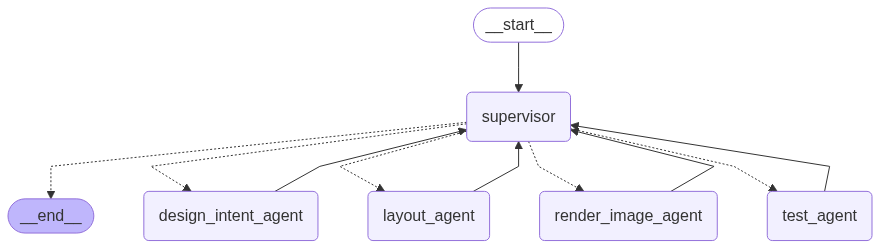

In [86]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

**Checking the workflow of the agent with simple prompt and how the supervisor controls all communication flow and task delegation.**

In [87]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "design, test and render a spooky maze level with 2 enemies and 1 trap",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_design_intent_agent

Successfully transferred to design_intent_agent


Update from node design_intent_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_layout_agent

Successfully transferred to layout_agent


Update from node layout_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_test_agent

Successfully transferred to test_agent


Update from node test_agent:


=

/tmp/ipython-input-84-3365861533.py:46: UserWarning: Glyph 128163 (\N{BOMB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-84-3365861533.py:48: UserWarning: Glyph 128163 (\N{BOMB}) missing from font(s) DejaVu Sans.
  plt.savefig(path, bbox_inches="tight", dpi=150)


Update from node render_image_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

Here is the final result: I have designed, tested, and rendered a spooky maze level with 2 enemies and 1 trap. The image of the level is available at /tmp/level.png.
```
[
    ["W", "W", "W", "W", "W", "W", "W", "W", "W", "W"],
    ["W", "S", "P", "P", "P", "P", "P", "P", "E", "W"],
    ["W", "P", "W", "W", "W", "W", "W", "P", "W", "W"],
    ["W", "P", "W", "P", "P", "P", "W", "P", "P", "W"],
    ["W", "P", "W", "P", "W", "P", "W", "W", "P", "W"],
    ["W", "P", "P", "P", "W", "P", "P", "P", "T", "W"],
    ["W", "W", "W", "W", "W", "W", "W", "P", "W", "W"],
    ["W", "E", "P", "P", "P", "P", "P", "P", "P", "W"],
    ["W", "W", "W", "W", "W", "W", "W", "W", "G",

AI agent has successfully designed, tested and rendered the simple maze level design with 2 enemies and 1 trap.

**Displaying the image of generated maze by multi agent**

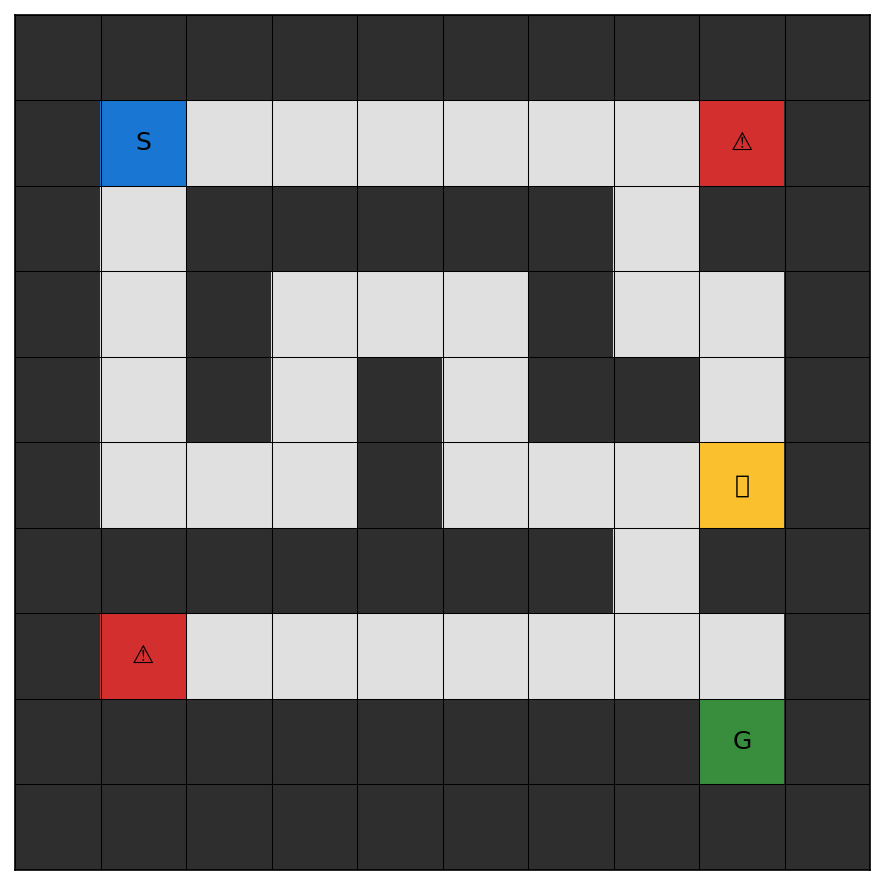

In [88]:
from IPython.display import Image, display

# Path to the rendered image
image_path = "/tmp/level.png"

# Display the image in Colab
display(Image(filename=image_path))

**Conclusion**

The Text-to-Level Maze Generator project successfully demonstrates the power of LangGraph's Multi-Agent Supervisor architecture for transforming natural language into playable 2D maze levels. The goal was to enable game developers to describe level ideas in plain English, and let a coordinated group of AI agents handle the rest — from design to visualization.